In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set manual seed for reproducibility
torch.manual_seed(0)

# Define simple feedforward neural network
class VesselPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 6)  # [x, y, psi, u, v, r]
        )

    def forward(self, t):
        return self.net(t)

# Vessel constants
M = torch.tensor([[3980.0, 0, 0],
                  [0, 3980.0, 0],
                  [0, 0, 19703.0]], dtype=torch.float32)
D_l = torch.tensor([50.0, 200.0, 1281.0], dtype=torch.float32)
D_q = torch.tensor([135.0, 2000.0, 0.0], dtype=torch.float32)
D_c = torch.tensor([0.0, 0.0, 3224.0], dtype=torch.float32)

def R_rot(psi):
    c, s = torch.cos(psi), torch.sin(psi)
    return torch.stack([
        torch.stack([c, -s, torch.zeros_like(c)]),
        torch.stack([s, c, torch.zeros_like(c)]),
        torch.stack([torch.zeros_like(c), torch.zeros_like(c), torch.ones_like(c)])
    ])

def pinn_loss(model, t, tau):
    t.requires_grad = True
    pred = model(t)
    eta = pred[:, :3]  # [x, y, psi]
    nu = pred[:, 3:]   # [u, v, r]

    # Compute time derivatives component-wise
    eta_dot = torch.stack([
        torch.autograd.grad(eta[:, i], t, torch.ones_like(eta[:, i]), create_graph=True)[0]
        for i in range(3)
    ], dim=1)

    nu_dot = torch.stack([
        torch.autograd.grad(nu[:, i], t, torch.ones_like(nu[:, i]), create_graph=True)[0]
        for i in range(3)
    ], dim=1)

    dyn_res, kin_res = [], []
    for i in range(len(t)):
        nu_i = nu[i]
        nu_dot_i = nu_dot[i]
        psi_i = eta[i, 2]

        # Damping
        D_i = D_l + D_q * torch.abs(nu_i) + D_c * nu_i ** 2
        D_mat = torch.diag(D_i)

        # Coriolis
        C = torch.tensor([
            [0, 0, -3980.0 * nu_i[1]],
            [0, 0, 3980.0 * nu_i[0]],
            [3980.0 * nu_i[1], -3980.0 * nu_i[0], 0]
        ], dtype=torch.float32)

        # Dynamics residual
        dyn = M @ nu_dot_i + D_mat @ nu_i + C @ nu_i - tau.squeeze()
        dyn_res.append(dyn)

        # Kinematics residual
        R = R_rot(psi_i)
        kin = eta_dot[i] - (R @ nu_i)
        kin_res.append(kin)

    dyn_res = torch.stack(dyn_res)
    kin_res = torch.stack(kin_res)
    return (dyn_res ** 2).mean() + (kin_res ** 2).mean()

# Create model and optimizer
model = VesselPINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

tau = torch.tensor([[500.0, 0.0, 200.0]], dtype=torch.float32)
t_train = torch.linspace(0, 50, 200).view(-1, 1)

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    loss = pinn_loss(model, t_train, tau)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


Epoch 0, Loss: 344608.937500
Epoch 100, Loss: 2884.867676
Epoch 200, Loss: 463.443573
Epoch 300, Loss: 154.501175
Epoch 400, Loss: 68.161430
Epoch 500, Loss: 39.957489
Epoch 600, Loss: 27.016582
Epoch 700, Loss: 19.406149
Epoch 800, Loss: 14.444162
Epoch 900, Loss: 11.064988
Epoch 1000, Loss: 8.732676
Epoch 1100, Loss: 7.123319
Epoch 1200, Loss: 6.010986
Epoch 1300, Loss: 5.229654
Epoch 1400, Loss: 4.660498
Epoch 1500, Loss: 4.222875
Epoch 1600, Loss: 135.031815
Epoch 1700, Loss: 3.610508
Epoch 1800, Loss: 3.345145
Epoch 1900, Loss: 3.141878
Epoch 2000, Loss: 3.240891
Epoch 2100, Loss: 2.709093
Epoch 2200, Loss: 2.500472
Epoch 2300, Loss: 2880.075195
Epoch 2400, Loss: 2.237710
Epoch 2500, Loss: 2.021648
Epoch 2600, Loss: 1.859961
Epoch 2700, Loss: 185.226593
Epoch 2800, Loss: 1.708220
Epoch 2900, Loss: 1.500267
Epoch 3000, Loss: 1.381251
Epoch 3100, Loss: 177.911362
Epoch 3200, Loss: 1.234465
Epoch 3300, Loss: 1.126017
Epoch 3400, Loss: 1.044011
Epoch 3500, Loss: 74.653450
Epoch 3600, 

In [33]:
t_np = t_train.detach().cpu().numpy()
pred_np = model(t_train).detach().cpu().numpy()


Text(0.5, 0, 'X')

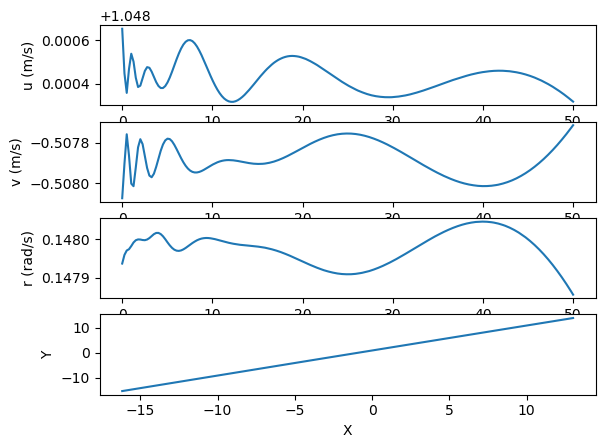

In [35]:
plt.subplot(411)
plt.plot(t_np, pred_np[:, 3])  # u
plt.ylabel('u (m/s)')

plt.subplot(412)
plt.plot(t_np, pred_np[:, 4])  # v
plt.ylabel('v (m/s)')

plt.subplot(413)
plt.plot(t_np, pred_np[:, 5])  # r
plt.ylabel('r (rad/s)')
plt.xlabel('Time (s)')

plt.subplot(414)
plt.plot(pred_np[:, 0], pred_np[:, 1])  # x,y
plt.ylabel('Y')
plt.xlabel('X')